In [1]:
# %pip install 'networkx<2.7'

In [2]:
# !pip install cdlib

In [3]:
import os
import heapq
import argparse
import threading
import multiprocessing
import sys
import queue


from __future__ import division
import math, time
from copy import deepcopy
import multiprocessing, json
from tqdm import tqdm
import heapq
import community

#importing libraries that will be used
# import networkx as nx#for creating network
# import numpy as np
# import matplotlib.pyplot as plt#for plotting plots
# import random
# import time#claculating time
# import math
# from collections import Counter
# from itertools import permutations
# from itertools import combinations

# from collections import defaultdict
# from scipy.io import mmread# to read dataset
# import pandas as pd



In [4]:
#importing libraries that will be used
import networkx as nx#for creating network
import numpy as np
import matplotlib.pyplot as plt#for plotting plots

import random
import time#claculating time
import math
from collections import Counter
from itertools import permutations
from itertools import combinations

from collections import defaultdict
from scipy.io import mmread# to read dataset
import pandas as pd

# from cdlib import algorithms

In [5]:
'''Implementation of SimPath algorithm'''

class CELFQueue:
    # create if not exist
    nodes = None
    q = None
    nodes_gain = None

    def __init__(self):
        self.q = []
        self.nodes_gain = {}

    def put(self, node, marginalgain):
        self.nodes_gain[node] = marginalgain
        heapq.heappush(self.q, (-marginalgain, node))

    def update(self, node, marginalgain):
        self.remove(node)
        self.put(node, marginalgain)

    def remove(self, node):
        self.q.remove((-self.nodes_gain[node], node))
        self.nodes_gain[node] = None
        heapq.heapify(self.q)

    def topn(self, n):
        top = heapq.nsmallest(n, self.q)
        top_ = list()
        for t in top:
            top_.append(t[1])
        return top_

    def get_gain(self, node):
        return self.nodes_gain[node]



def init_D(graph):
    D = {}
#     for i in range(graph.node_num + 1):
    for i in graph.nodes:
        D[i]=[]
    return D

class Graph:
    nodes = None
    edges = None
    children = None
    parents = None
    node_num = None
    edge_num = None

    def __init__(self, nodes, edges, children, parents, node_num, edge_num):
        self.nodes = nodes
        self.edges = edges
        self.children = children
        self.parents = parents
        self.node_num = node_num
        self.edge_num = edge_num
#         print("Numnodes:",self.node_num)
    def get_children(self, node):
        ch = self.children.get(node)
        if ch is None:
            self.children[node] = []
        return self.children[node]

    def get_parents(self, node):
        pa = self.parents.get(node)
        if pa is None:
            self.parents[node] = []
        return self.parents[node]

    def get_weight(self, src, dest):
        weight = self.edges.get((src, dest))
        if weight is None:
            return 0
        else:
            return weight

    # return true if node1 is parent of node 2 , else return false
    def is_parent_of(self, node1, node2):
        if self.get_weight(node1, node2) != 0:
            return True
        else:
            return False

    # return true if node1 is child of node 2 , else return false
    def is_child_of(self, node1, node2):
        return self.is_parent_of(node2, node1)

    def get_out_degree(self, node):
        return len(self.get_children(node))

    def get_in_degree(self, node):
        return len(self.get_parents(node))


def read_graph_info(path):
    if os.path.exists(path):
        parents = {}
        children = {}
        edges = {}
        nodes = set()

        try:
            f = open(path, 'r')
            txt = f.readlines()
            header = str.split(txt[0])
            node_num = int(header[0])
            edge_num = int(header[1])

            for line in txt[1:]:
#                 print("line:",line)
                row = str.split(line)
#                 print(row)
                src = int(row[0])
                des = int(row[1])
                nodes.add(src)
                nodes.add(des)
#                 print(src,des)
                if children.get(src) is None:
                    children[src] = []
                if parents.get(des) is None:
                    parents[des] = []

#                 weight = float(row[2])
                weight=round(random.uniform(0.0,1.0),2)
                edges[(src, des)] = weight
                children[src].append(des)
                parents[des].append(src)

            return list(nodes), edges, children, parents, node_num, edge_num
        except IOError:
            print('IOError')
    else:
        print('file can not found')




# def get_vertex_cover(graph):
#     # dv[i] out degree of node i+1
#     dv = np.zeros(graph.node_num)
#     # e[i,j] = 0: edge (i+1,j+1),(j+1,i+1) checked
#     check_array = np.zeros((graph.node_num, graph.node_num))
#     checked = 0
# #     print(range(graph.node_num))
#     for i in range(graph.node_num):
#         # for a edge (i,j) and (j,i) may be count twice but the algorithm is to find a vertex cover. it doesn't mater
#         dv[i] = graph.get_out_degree(i + 1) + graph.get_in_degree(i + 1)
#     # V: Vertex cover
#     V = set()
# #     print(dv)
#     while checked < graph.edge_num:
#         s = dv.argmax() + 1
#         V.add(s)
#         # make sure that never to select this node again
#         children = graph.get_children(s)
#         parents = graph.get_parents(s)
#         for child in children:
#             if check_array[s - 1][child - 1] == 0:
#                 check_array[s - 1][child - 1] = 1
#                 checked = checked + 1
#         for parent in parents:
#             if check_array[parent - 1][s - 1] == 0:
#                 check_array[parent - 1][s - 1] = 1
#                 checked = checked + 1
#         dv[s - 1] = -1
#     return list(V)



def forward(Q, D, spd, pp, r, W, U, spdW_u, graph):
    x = Q[-1]
    if U is None:
        U = []
    children = graph.get_children(x)
    count = 0
    while True:
        # any suitable chid is ok

#         for child in range(count, len(children)):
        flag=1
        for y in children:

#             print("y,D[x],type:",y,D[x],type(D[x]))
#             if(y not in D[x]):
#                 print("YES")

            if (y in W) and (y not in Q) and (y not in D[x]):
#                 y = children[child]
                flag=0
                break
#             count = count + 1

        # no such child:
        if flag==1:
            return Q, D, spd, pp

        if pp * graph.get_weight(x, y) < r:
            D[x].append(y)
        else:
            Q.append(y)
            pp = pp * graph.get_weight(x, y)
            spd = spd + pp
            D[x].append(y)
            x = Q[-1]
            for v in U:
                if v not in Q:
                    spdW_u[v] = spdW_u[v] + pp
            children = graph.get_children(x)
            count = 0



def backtrack(u, r, W, U, spdW_, graph):
    Q = [u]
    spd = 1
    pp = 1
    D = init_D(graph)

    while len(Q) != 0:
        Q, D, spd, pp = forward(Q, D, spd, pp, r, W, U, spdW_, graph)
        u = Q.pop()
#         print("In backtrack:type,Q,u",type(Q),Q,u)
        D[u] = []
        if len(Q) != 0:
            v = Q[-1]
            pp = pp / graph.get_weight(v, u)
    return spd



def simpath_spread(S, r, U, graph, spdW_=None):
    spread = 0
    # W: V-S
    W = set(graph.nodes).difference(S)
    if U is None or spdW_ is None:
        spdW_={}
        for i in graph.nodes:
            spdW_[i]=0
#         spdW_ = np.zeros(graph.node_num + 1)
        # print 'U None'
    for u in S:
        W.add(u)
        # print spdW_[u]
        spread = spread + backtrack(u, r, W, U, spdW_[u], graph)
        # print spdW_[u]
        W.remove(u)
    return spread





def simpath(graph, k, r, l):
    C = set(get_vertex_cover(graph))
    V = set(graph.nodes)

    V_C = V.difference(C)
    # spread[x] is spd of S + x
#     spread = np.zeros(graph.node_num + 1)
    spread={}
    for i in graph.nodes:
        spread[i]=0
#     spdV_ = np.ones((graph.node_num + 1, graph.node_num + 1))
    spdV_={}
    for i in graph.nodes:
        dd={}
        for j in graph.nodes:
            dd[j]=0
        spdV_[i]=dd


    for u in C:
        U = V_C.intersection(set(graph.get_parents(u)))
        spread[u] = simpath_spread(set([u]), r, U, graph, spdV_)
    for v in V_C:
        v_children = graph.get_children(v)
        for child in v_children:
            spread[v] = spread[v] + spdV_[child][v] * graph.get_weight(v, child)
        spread[v] = spread[v] + 1
    celf = CELFQueue()
    # put all nodes into celf queqe
    # spread[v] is the marginal gain at this time

#     for node in range(1, graph.node_num + 1):
#         celf.put(node, spread[node])
    for node in graph.nodes:
        celf.put(node, spread[node])

    S = set()
    W = V
    spd = 0
    # mark the node that checked before during the same Si
#     checked = np.zeros(graph.node_num + 1)
    checked={}
    for i in graph.nodes:
        checked[i]=0

    while len(S) < k:
        U = celf.topn(l)
#         spdW_ = np.ones((graph.node_num + 1, graph.node_num + 1))
#         spdV_x = np.zeros(graph.node_num + 1)

        spdW_={}
        spdV_x={}
        for i in graph.nodes:
            dd={}
            spdV_x[i]=0
            for j in graph.nodes:
                dd[j]=1
            spdW_[i]=dd

        simpath_spread(S, r, U, graph, spdW_=spdW_)
        for x in U:
            for s in S:
                spdV_x[x] = spdV_x[x] + spdW_[s][x]
        for x in U:
            if checked[x] != 0:
                S.add(x)
                W = W.difference(set([x]))
                spd = spread[x]
                # print spread[x],simpath_spread(S,r,None,None)
#                 checked = np.zeros(graph.node_num + 1)
#                 for i in graph.nodes:
#                     checked[i]=0
                celf.remove(x)
                break
            else:
                spread[x] = backtrack(x, r, W, None, None, graph) + spdV_x[x]
                checked[x] = 1
                celf.update(x, spread[x] - spd)
    return S



# node,edges,children,parents,nodenum,edge_num=read_graph_info('dolphins.txt') #Input dataset with 'total nodes' and 'total edges' in the 'first line'
# graph = Graph(node,edges,children,parents,nodenum,edge_num)
# seeds = simpath(graph, 3, 0.5, 4)
# print("seed:",seeds)



def SIMPATH_setup(G):
    parents = {}
    children = {}
    edges = {}
    nodes = set()
    node_num = len(G.nodes())
    edge_num = len(G.edges())
#     print(node_num,edge_num)
    for src,des in G.edges():
        nodes.add(src)
        nodes.add(des)
        if children.get(src) is None:
            children[src] = []
        if parents.get(des) is None:
            parents[des] = []
        weight=G[src][des]['weight']
        edges[(src, des)] = weight
        children[src].append(des)
        parents[des].append(src)
    return list(nodes), edges, children, parents, node_num, edge_num

def run_SIMPATH(G,k):
    node,edges,children,parents,nodenum,edge_num=SIMPATH_setup(G)
    graph = Graph(node,edges,children,parents,nodenum,edge_num)
    seeds = simpath(graph, k, 0.5, k+1)
    return list(seeds)




def get_vertex_cover(graph):
#     dv = np.zeros(graph.node_num)
    dv=dict()
#     check_array = np.zeros((graph.node_num, graph.node_num))
    check_array={}
    for i in graph.nodes:
        dd={}
        for j in graph.nodes:
            dd[j]=0
        check_array[i]=dd

#     checked = 0

#     for i in range(graph.node_num):
#         dv[i] =graph.get_out_degree(i + 1) + graph.get_in_degree(i + 1)
    for i in graph.nodes:
        dv[i]=graph.get_out_degree(i) + graph.get_in_degree(i)

    # V: Vertex cover
    V = set()
#     while checked < graph.edge_num:
    for checked in graph.nodes:
#         s = dv.argmax() + 1
        _,s=max(zip(dv.values(), dv.keys()))
        V.add(s)
        # make sure that never to select this node again
        children = graph.get_children(s)
        parents = graph.get_parents(s)
        for child in children:
            if check_array[s][child] == 0:
                check_array[s][child] = 1
#                 checked = checked + 1
        for parent in parents:
            if check_array[parent][s] == 0:
                check_array[parent][s] = 1
#                 checked = checked + 1
        dv[s] = -1
#     print("In Vertex conver V is:",V)
    return list(V)


In [6]:
''' Implementation of PMIA algorithm [1].
[1] -- Scalable Influence Maximization for Prevalent Viral Marketing in Large-Scale Social Networks.
'''


def updateAP(ap, S, PMIIAv, PMIIA_MIPv, Ep):
    ''' Assumption: PMIIAv is a directed tree, which is a subgraph of general G.
    PMIIA_MIPv -- dictionary of MIP from nodes in PMIIA
    PMIIAv is rooted at v.
    '''
    # going from leaves to root
    sorted_MIPs = sorted(PMIIA_MIPv.items(), key = lambda MIP: len(MIP), reverse = True)
#     print("Edges:",PMIIAv.nodes)
#     for e in PMIIAv.edges:
#         print(e)
#     for u,_ in sorted_MIPs:
#         print(u,_)


    for u, _ in sorted_MIPs:
        if u in S:
            ap[(u, PMIIAv)] = 1
        elif not PMIIAv.in_edges([u]):
#             print("\n\nGoin in elif")
            ap[(u, PMIIAv)] = 0
        else:
            in_edges = PMIIAv.in_edges([u], data=True)
            prod = 1
            for w, _, edata in in_edges:
                # p = (1 - (1 - Ep[(w, u)])**edata["weight"])

                print("In updateAP")
                print("hello:",w,PMIIAv)
                if (w,PMIIAv) in ap.keys():
                    print("Key present")
                else:
                    print("Key is NOT present")
#                 print("keys:",

                p = Ep[(w,u)]
                prod *= 1 - ap[(w, PMIIAv)]*p
#             print(ap,u, PMIIAv)
            ap[(u, PMIIAv)] = 1 - prod

def updateAlpha(alpha, v, S, PMIIAv, PMIIA_MIPv, Ep, ap):
    # going from root to leaves
    sorted_MIPs =  sorted(PMIIA_MIPv.items(), key = lambda MIP: len(MIP))
    for u, mip in sorted_MIPs:
        if u == v:
            alpha[(PMIIAv, u)] = 1
        else:
            out_edges = PMIIAv.out_edges([u])
            assert len(out_edges) == 1, "node u=%s must have exactly one neighbor, got %s instead" %(u, len(out_edges))
            out_edges=list(out_edges)
#             print("out_edges:",out_edges,type(out_edges))

            w = out_edges[0][1]
            if w in S:
                alpha[(PMIIAv, u)] = 0
            else:
                in_edges = PMIIAv.in_edges([w], data=True)
                prod = 1
                for up, _, edata in in_edges:
                    if up != u:
                        # pp_upw = 1 - (1 - Ep[(up, w)])**edata["weight"]
                        pp_upw = Ep[(up, w)]
                        prod *= (1 - ap[up]*pp_upw)
                # alpha[(PMIIAv, u)] = alpha[(PMIIAv, w)]*(1 - (1 - Ep[(u,w)])**PMIIAv[u][w]["weight"])*prod
                alpha[(PMIIAv, u)] = alpha[(PMIIAv, w)]*(Ep[(u,w)])*prod

def computePMIOA(G, u, theta, S, Ep):
    '''
     Compute PMIOA -- subgraph of G that's rooted at u.
     Uses Dijkstra's algorithm until length of path doesn't exceed -log(theta)
     or no more nodes can be reached.
    '''
    # initialize PMIOA
    PMIOA = nx.DiGraph()
    PMIOA.add_node(u)
    PMIOA_MIP = {u: [u]} # MIP(u,v) for v in PMIOA

    crossing_edges = set([out_edge for out_edge in G.out_edges([u]) if out_edge[1] not in S + [u]])
    edge_weights = dict()
    dist = {u: 0} # shortest paths from the root u

    # grow PMIOA
    while crossing_edges:
        # Dijkstra's greedy criteria
        min_dist = float("Inf")
        sorted_crossing_edges = sorted(crossing_edges) # to break ties consistently
        for edge in sorted_crossing_edges:
            if edge not in edge_weights:
                # edge_weights[edge] = -math.log(1 - (1 - Ep[edge])**G[edge[0]][edge[1]]["weight"])
                edge_weights[edge] = -math.log(Ep[edge])
            edge_weight = edge_weights[edge]
            if dist[edge[0]] + edge_weight < min_dist:
                min_dist = dist[edge[0]] + edge_weight
                min_edge = edge
        # check stopping criteria
        if min_dist < -math.log(theta):
            dist[min_edge[1]] = min_dist
            # PMIOA.add_edge(min_edge[0], min_edge[1], {"weight": G[min_edge[0]][min_edge[1]]["weight"]})
            PMIOA.add_edge(min_edge[0], min_edge[1])
            PMIOA_MIP[min_edge[1]] = PMIOA_MIP[min_edge[0]] + [min_edge[1]]
            # update crossing edges
            crossing_edges.difference_update(G.in_edges(min_edge[1]))
            crossing_edges.update([out_edge for out_edge in G.out_edges(min_edge[1])
                                   if (out_edge[1] not in PMIOA) and (out_edge[1] not in S)])
        else:
            break
    return PMIOA, PMIOA_MIP

def updateIS(IS, S, u, PMIOA, PMIIA):
    for v in PMIOA[u]:
        for si in S:
            # if seed node is effective and it's blocked by u
            # then it becomes ineffective
            if (si in PMIIA[v]) and (si not in IS[v]) and (u in PMIIA[v][si]):
                    IS[v].append(si)

def computePMIIA(G, ISv, v, theta, S, Ep):

    # initialize PMIIA
    PMIIA = nx.DiGraph()
    PMIIA.add_node(v)
    PMIIA_MIP = {v: [v]} # MIP(u,v) for u in PMIIA

    crossing_edges = set([in_edge for in_edge in G.in_edges([v]) if in_edge[0] not in ISv + [v]])
    edge_weights = dict()
    dist = {v: 0} # shortest paths from the root u

    # grow PMIIA
    while crossing_edges:
        # Dijkstra's greedy criteria
        min_dist = float("Inf")
        sorted_crossing_edges = sorted(crossing_edges) # to break ties consistently
        for edge in sorted_crossing_edges:
            if edge not in edge_weights:
                # edge_weights[edge] = -math.log(1 - (1 - Ep[edge])**G[edge[0]][edge[1]]["weight"])
#                 edgevalue=Ep[edge]
#                 print("Ep[edge]:",Ep[edge],edgevalue)
                edge_weights[edge] = -(math.log(Ep[edge]))
#                 edge_weights[edge] = -(math.log(edgevalue))

            edge_weight = edge_weights[edge]
            if dist[edge[1]] + edge_weight < min_dist:
                min_dist = dist[edge[1]] + edge_weight
                min_edge = edge
        # check stopping criteria
        # print min_edge, ':', min_dist, '-->', -math.log(theta)
        if min_dist < -math.log(theta):
            dist[min_edge[0]] = min_dist
            # PMIIA.add_edge(min_edge[0], min_edge[1], {"weight": G[min_edge[0]][min_edge[1]]["weight"]})
            PMIIA.add_edge(min_edge[0], min_edge[1])
            PMIIA_MIP[min_edge[0]] = PMIIA_MIP[min_edge[1]] + [min_edge[0]]
            # update crossing edges
            crossing_edges.difference_update(G.out_edges(min_edge[0]))
            if min_edge[0] not in S:
                crossing_edges.update([in_edge for in_edge in G.in_edges(min_edge[0])
                                       if (in_edge[0] not in PMIIA) and (in_edge[0] not in ISv)])
        else:
            break
    return PMIIA, PMIIA_MIP

def PMIA(G, k, theta, Ep):
    start = time.time()
    # initialization
    S = []
    IncInf = dict(zip(G.nodes(), [0]*len(G)))
    PMIIA = dict() # node to tree
    PMIOA = dict()
    PMIIA_MIP = dict() # node to MIPs (dict)
    PMIOA_MIP = dict()
    ap = dict()
    alpha = dict()
    IS = dict()
    for v in G:
        IS[v] = []
        PMIIA[v], PMIIA_MIP[v] = computePMIIA(G, IS[v], v, theta, S, Ep)
        for u in PMIIA[v]:
            ap[u] = 0 # ap of u node in PMIIA[v]
        updateAlpha(alpha, v, S, PMIIA[v], PMIIA_MIP[v], Ep, ap)
        for u in PMIIA[v]:
            IncInf[u] += alpha[(PMIIA[v], u)]*(1 - ap[u])
#     print('Finished initialization')
#     print(time.time() - start)

    # main loop
    for i in range(k):
#         print(IncInf)
#         u, _ = max(IncInf.items(), key = lambda dk, dv: dv)
        _,u=max(zip(IncInf.values(), IncInf.keys()))
        IncInf.pop(u) # exclude node u for next iterations
        PMIOA[u], PMIOA_MIP[u] = computePMIOA(G, u, theta, S, Ep)
        for v in PMIOA[u]:
            for w in PMIIA[v]:
                if w not in S + [u]:
                    IncInf[w] -= alpha[(PMIIA[v],w)]*(1 - ap[w])

        updateIS(IS, S, u, PMIOA_MIP, PMIIA_MIP)

        S.append(u)

        for v in PMIOA[u]:
            if v != u:
                PMIIA[v], PMIIA_MIP[v] = computePMIIA(G, IS[v], v, theta, S, Ep)


                for uu in PMIIA[v].nodes:
                    if uu in S:
#                         print("IN s")
                        ap[u] = 1
                    elif not PMIIA[v].in_edges([uu]):
#                         print("Second else if")
            #             print("\n\nGoin in elif")
                        ap[uu] = 0
                    else:
                        in_edges = PMIIA[v].in_edges([uu], data=True)
                        prod = 1
#                         print("inEdgessss:",in_edges)
                        for w, _, edata in in_edges:
                            # p = (1 - (1 - Ep[(w, u)])**edata["weight"]
                            p = Ep[(w,uu)]
                            prod *= 1 - ap[w]*p
                        ap[uu] = 1 - prod

#                 updateAP(ap, S, PMIIA[v], PMIIA_MIP[v], Ep)
                updateAlpha(alpha, v, S, PMIIA[v], PMIIA_MIP[v], Ep, ap)
                # add new incremental influence
                for w in PMIIA[v]:
                    if w not in S:
                        IncInf[w] += alpha[(PMIIA[v], w)]*(1 - ap[w])

    return S

def getCoverage(G, S, Ep):
    return IC(G, S)


def run_PMIA(GG,k):
    Ep = dict()
    G=nx.DiGraph()
    for edgee in GG.edges():
        s=edgee[0]
        t=edgee[1]
        Ep[(int(s), int(t))] = GG[s][t]['weight']
        G.add_edge(s,t,weight=GG[s][t]['weight'])
        G.nodes[s]['thres']=(G.degree(s)/2)
        G.nodes[t]['thres']=(G.degree(t)/2)
    theta = 1.0/20
    S = PMIA(G, k, theta, Ep)
    return S


In [7]:
def read_txt(path):
  file1 = open(path,'r')
  sender = list()
  receiver = list()

  for i in file1.readlines():
    sender.append(int(i.split(' ')[0]))
    receiver.append(int(i.split(' ')[1].split('\n')[0]))

  df = pd.DataFrame(list(zip(sender,receiver)),columns =['source', 'target'])
  return df

In [8]:
def gmltotxt(filename):
    import networkx as nx
    import pandas as pd
    g = nx.read_gml('airlines.gml')
    nx.write_edgelist(g, 'edgelistFile.csv', delimiter=',')
    df = pd.read_csv('edgelistFile.csv')
    file = open("myfile.txt","w")
    for i in range(len(df)):
        x=df.iloc[i][0]
        y=df.iloc[i][1]
        file.write(str(x)+" "+str(y)+"\n")
    file.close()

In [9]:
def getcand(G,k, comm):#Take df and  all new nodes as input and return a seed node.
    s=[]
    s=GreedyDiv(G,k, comm)
    return s

In [10]:
def linear_Threshold(graph, seeds):
    seeds=list(seeds)
    influnces = seeds[:]
    queue = influnces[:]
    pre_node_record = defaultdict(float)
#     print("Queue:",queue)

#     print("Influences:",influnces)
    while len(queue) != 0:
        node = queue.pop(0)
#         print("----------------------------------------------------------------------")
#         print("Take node:",node)
#         print("Neighbour:",graph[node])
        for element in graph[node]:
            if element not in influnces:
#                 print("Element:",element,"prerecored",pre_node_record[element])
                pre_node_record[element] = pre_node_record[element] + graph[node][element]['weight']
#                 print(pre_node_record[element])
                if pre_node_record[element] >= graph.nodes[element]['thres']:
#                     print(">>>>>>>>>>>>>>>>>>node influeced:",element)
                    influnces.append(element)
                    queue.append(element)
#     influnce_num = len(influnces)
#     print("Seed set:",seeds,"Activated nodes:",influnces)
    return influnces
# linear_Threshold(GG,[45,29])

In [11]:
def communityDiversityFunction(G,activated,communities):
    noofcommunity=0
    summ=0
#     print("Communities:",communities)
#     print("activated:",activated)
    for com in communities:
        current=0
        if any(x in activated for x in com):
            common_elements = set(com).intersection(set(activated))
#             print("Com:",com," Activated:",activated,"comm:",common_elements,len(common_elements))
            current=len(common_elements)/len(com)
#             print("Current:",current)
            noofcommunity=noofcommunity+1
        summ+=current
#         print("Sum:",product)
    if noofcommunity==0:
        noofcommunity=1
    summ=summ*(noofcommunity/len(communities))
    return summ


In [12]:
def compute_Phi_dbim(G, S, communities):
    if len(S)<1:
        return 0
    lambda_G = 0.5
    v_length = G.number_of_nodes()

    IC_S = IC(G, S)
    activated_set_S_length = len(IC_S)
    diversity_activated_set_S = communityDiversityFunction(G, IC_S, communities)
#     diversity_V = len(communities)
#     diversity_V = activated_set_S_length
#     print("diversity_activated_set_S: ", diversity_activated_set_S)
#     print("diversity_V: ", diversity_V)
    phi_S = ((1 - lambda_G)* (activated_set_S_length/v_length)) + (lambda_G * (diversity_activated_set_S))
    return phi_S,IC_S


In [13]:
def compute_Phi(G, S, communities):
    if len(S)<1:
        return 0
    lambda_G = 0.5
    v_length = G.number_of_nodes()

    IC_S = IC(G, S)
    activated_set_S_length = len(IC_S)
    diversity_activated_set_S = communityDiversityFunction(G, IC_S, communities)
#     diversity_V = len(communities)
#     diversity_V = activated_set_S_length
#     print("diversity_activated_set_S: ", diversity_activated_set_S)
#     print("diversity_V: ", diversity_V)
    phi_S = ((1 - lambda_G)* (activated_set_S_length/v_length)) + (lambda_G * (diversity_activated_set_S))
    return phi_S


In [14]:

# obj=TBCD_mine()
# perc=[20,40,60,80]
# filename='200_0'
# print("hello")
# obj.execute_TBCD_txt(filename,perc)

In [15]:
def findk(i):#dynamic calculation of k according the percentage of current dataset
  k=(0.01*i)
  if(i==0):
    k=1
  if(k>int(k)):
   k=int(k)+1
  return k

In [16]:
def displayresult(result,itr,perc):
    print("\n\n\n\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

    linestylee=['dashdot','dashed','dotted','-', '--', ':','-.','dashed','dotted','-', '--', ':','-.' ]

    markerss = ['o','v','s','*','+','x','D','d','X','P','+','x','D','d','X','P']
#     descriptions = ['circle', 'triangle_down','square','star', 'plus','x','diamond', 'thin_diamond','x (filled)','plus (filled)']
    communitiesITR=[]
    Name=[]
    activatednodesITR=[]
    totalcomm=[]
    timeITR=[]
    tt=[]
#     print(itr,result)

    for i in result:
        for j in range(len(result[i])):
            Name.append(result[i][j]['Name'])
        break
#     print(Name)

#     for i in result:
# #         print(result[i])
#         for j in range(len(result[i])):
#             totalcomm.append(result[i][j]['Total communitites'])
#             break
#     print("Total communitites:",totalcomm)

    for i in result:
        active=[]
        comm=[]
        tt=[]
        for j in range(len(result[i])):
            active.append(result[i][j]['length of activated nodes'])
            comm.append(result[i][j]['number of communities'])
            tt.append(result[i][j]['time'])
        activatednodesITR.append(active)
        communitiesITR.append(comm)
        timeITR.append(tt)
#     print("Activated nodes:",activatednodesITR)
#     print("Communities:",communitiesITR)



#     print("hello");

    plt.xlabel("Percentage")
    plt.ylabel("Activated nodes")
    plt.title("Activated nodes")
    for i in range(len(activatednodesITR[0])):
        plt.plot(perc,[pt[i] for pt in activatednodesITR],label = '%s'%Name[i],linestyle='%s'%linestylee[i],marker='%s'%markerss[i])
    plt.legend()
    plt.show()


    plt.xlabel("Percentage")
    plt.ylabel("No of community")
    plt.title("Communitites")
    for i in range(len(communitiesITR[0])):
        plt.plot(perc,[pt[i] for pt in communitiesITR],label = '%s'%Name[i],linestyle='%s'%linestylee[i],marker='%s'%markerss[i])
#     plt.plot(perc,totalcomm,label='Total community',linestyle='%s'%linestylee[-1],marker='%s'%markerss[-1])
    plt.legend()
    plt.show()

    print("communities:",len(communitiesITR[0]))
    print("Time:",len(timeITR[0]))
#     print("Percentage:",)
    #plt.figure(figsize=(12,8))
    plt.xlabel("Percentage")
    plt.ylabel("Execution time:")
    plt.title("Execution time")
    for i in range(len(timeITR[0])):
        plt.plot(perc,[pt[i] for pt in timeITR],label = '%s'%Name[i],linestyle='%s'%linestylee[i],marker='%s'%markerss[i])
#     plt.plot(perc,totalcomm,label='Total community',linestyle='%s'%linestylee[-1],marker='%s'%markerss[-1])
    plt.legend()
    plt.show()


In [17]:
def IC(graph, seed_set, threshold=0.5):
    activated_nodes = set(seed_set)
    new_nodes = set(seed_set)

    while new_nodes:
        current_nodes = list(new_nodes)
        new_nodes = set()

        for node in current_nodes:
            neighbors = set(graph.neighbors(node)) - activated_nodes
            for neighbor in neighbors:
                edge_weight = graph[node][neighbor]['weight']
                if edge_weight >= threshold:
                    new_nodes.add(neighbor)
                    activated_nodes.add(neighbor)

    return activated_nodes

In [18]:
def findcommunity(G,seedset,budget, comm,algoname,time):

    print ("Communities formed: ",len(comm))
    activated = IC(G, seedset)
    noofcommunity=0
    for com in comm:
        if any(x in activated for x in com):
            noofcommunity=noofcommunity+1
    print("Community we got:",noofcommunity)

    upperBound_dict = {
        'Name':algoname,
        'budget': budget,
#         'Total communitites':len(comm),
        'number of communities':noofcommunity,
        'length of activated nodes': len(activated),
        'time': time

        # 'length of communities': len(community_df['Unnamed: 1'].unique())
    }
    print(upperBound_dict)
    return upperBound_dict

In [19]:
def Greedy(G, budget, candidate_nodes):
    Dict = {}
    mySet1 = []
    cost = 0

    while cost < budget:
        for v in (set(candidate_nodes) - set(mySet1)):
            if cost + G.nodes[v]['cost'] > budget:
                continue
            mySet1.append(v)
            a = IC(G, mySet1)
            Dict[v] = len(a)  # influence as value and current node as key
            mySet1.remove(v)  # remove current node from mySet for rest nodes to go for IC

        if not Dict:
            break

        Keymax = max(zip(Dict.values(), Dict.keys()))[1]  # finding node with max influence
        mySet1.append(Keymax)
        cost = cost + G.nodes[Keymax]['cost']
        Dict.clear()

    return set(mySet1)


In [20]:
def cgim_IC(graph,budget,candidate_nodes):
    S = set()
    total_cost = 0
    influence = 0
    cnt=0
    influenced_nodes=[]
    while total_cost < budget:
        max_marginal_gain = -1
        chosen_node = None
        cnt+=1
        temp_inodes=[]

        for node in candidate_nodes:
            if (total_cost + graph.nodes[node].get('cost', 0)) < budget:
                S.add(node)
                temp_inodes = IC(graph, S)
                temp_influence=len(temp_inodes)
                S.remove(node)
                marginal_gain = temp_influence - influence

                if marginal_gain > max_marginal_gain:
                    influenced_nodes=temp_inodes
                    chosen_node = node
                    max_marginal_gain = marginal_gain

        if chosen_node==None:
          break

        # Removing influenced Node
        for node in influenced_nodes:
          if node in candidate_nodes:
            candidate_nodes.remove(node)

        S.add(chosen_node)
        total_cost = total_cost + graph.nodes[chosen_node].get('cost', 0)
        influence = influence + max_marginal_gain

        #candidate_nodes.remove(chosen_node)

    return S



In [21]:
# from diffusion_dynamic import IndependentCascade


# from diffusion_dynamic import IndependentCascade
import numpy as np
import random
import operator
import heapq

population_size = 50
mutation_rate = 0.3
crossover_rate = 1.0
elite_number = 2
mc = 1

def roulette_wheel_selection(population, fitnesses):
    total_fitness = sum(fitnesses)
    pick = random.uniform(0, total_fitness)
    current = 0
    for i in range(len(population)):
        current += fitnesses[i]
        if current > pick:
            return population[i]

def ordered_crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    
    child = [None] * size
    child[start:end] = parent1[start:end]
    for gene in parent2:
        if gene not in child:
            for i in range(size):
                if child[i] is None:
                    child[i] = gene
                    break
    return child

def mutation(child, V):
    m = random.sample(sorted(set(V).difference(child)), len(child))
    for i in range(len(child)):
        r = random.random()
        if r < mutation_rate:
            child[i] = m[i]
    return child
            
def fitness(child, diffuse, t0, duration):
    f = diffuse.diffuse_mc(child, mc=mc, t0=t0, duration=duration)
    return f

def find_max_indices(arr, k):
    max_values = heapq.nlargest(k, arr)
    indices = [i for i, num in enumerate(arr) if num in max_values]
    return indices
    

def genetic_algorithm(graph, diffuse, k, t0, duration):
    V = sorted(set(graph.nodes()))
    print(type(V))
    population = [random.sample(V, k) for _ in range(population_size)]
    generations = population_size * k
    print("evolution start, total generations: " + str(generations))
    for gen in range(generations):
#         print("generation: " + str(gen))
        #fitness
        fitnesses = [fitness(child, diffuse, t0, duration) for child in population]
        
        #select
        selected = [roulette_wheel_selection(population, fitnesses) for _ in range(population_size)]
        
        #crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = selected[i], selected[i + 1]
            if (random.random() < crossover_rate):
                child1, child2 = ordered_crossover(parent1, parent2), ordered_crossover(parent2, parent1)
            else:
                child1, child2 = parent1, parent2
            offspring += [child1, child2]
        
        #mutation
        mutated_offspring = [mutation(child, V) for child in offspring]
        
        #elitism
        indices = find_max_indices(fitnesses, elite_number)
        for i in indices:
            mutated_offspring[i] = population[i]
        #update population
        population = mutated_offspring
    
    #best seed
    fitnesses = [fitness(child, diffuse, t0, duration) for child in population]
    indices = find_max_indices(fitnesses, 1)
    return population[indices[0]], fitnesses[indices[0]],population,fitnesses
        
        
        
        
        
        


import numpy as np
import networkx as nx
from tqdm.autonotebook import tqdm


def diffuse_dynamic0(graph, edge_probs, edge_count_map_list, reverse_edge_idx, act_nodes, t0, duration):
    new_act_nodes = set(act_nodes)
    live_edges = np.zeros([1, len(edge_probs)], dtype = np.int8)
    t1 = min(len(edge_count_map_list), t0 + duration)
    for t in range(t0, t1):
        edge_count_map = edge_count_map_list[t]
        inc_nodes = set()
        for idx in edge_count_map.keys():
            edge = reverse_edge_idx[idx]
            count = edge_count_map[idx]
            if edge[0] not in new_act_nodes:
                continue
            r = np.random.random()
            if r > edge_probs[edge] ** count:
                live_edges[0][idx] = 1
                inc_nodes.add(edge[1])
        new_act_nodes.update(inc_nodes)
    return len(new_act_nodes)

class IndependentCascade(object):
    """
    Args:
        graph: networkx.DiGraph()
        edge_idx: {(u, v): i for i, (u, v) in enumerate(graph.edges())}
        temporal[t][i]: At time t, the edge (u, v) is effctive whose edge_idx == temporal[t][i]. 
        Given t, if there are many i to make temporal[t][i] the same, then the probability increases in power for edge (u, v).
        If temporal == None, then the network is static.
    """
    def __init__(self, graph, edge_idx, temporal = None):
        self.graph = graph
        self.sampled_graph = graph.copy()
        self.edge_idx = {(u, v): i for i, (u, v) in enumerate(self.graph.edges())}
        self.edge_probs = {(u, v): d['prob'] for u, v, d in graph.edges().data()}
        self.temporal = temporal
        self.reverse_edge_idx = {i: e for e, i in self.edge_idx.items()}
        self.prob_matrix = [self.graph.edges[self.reverse_edge_idx[i][0], self.reverse_edge_idx[i][1]]['prob'] for i in sorted(self.reverse_edge_idx.keys())]
        self.edge_count_map_list = []
        for t in range(len(temporal)):
            edge_idx_list = temporal[t]
            edge_count_map = {}
            for idx in edge_idx_list:
                if idx in edge_count_map:
                    edge_count_map[idx] += 1
                else:
                    edge_count_map[idx] = 1
            self.edge_count_map_list.append(edge_count_map)
    
    def sample_live_graph_mc(self, act_nodes, mc):
        edge_probs = {(u, v): d['prob'] for u, v, d in self.graph.edges().data()}
        probs = np.random.uniform(size=(mc, len(edge_probs)))
        self.sampled_graphs = []
        for p in probs:
            live_edges = np.array([p > self.prob_matrix]).astype(np.int8)
            self.sampled_graphs.append(live_edges)
    
    def diffuse_dynamic(self, act_nodes, t0, duration):
        return diffuse_dynamic0(self.graph, self.edge_probs, self.edge_count_map_list, self.reverse_edge_idx, act_nodes, t0, duration)
        
    def sample_live_graph(self, mcount):
        removed_edges_idx = np.where(self.sampled_graphs[mcount] == 0)[1].tolist()
        removed_edges = [self.reverse_edge_idx[i] for i in removed_edges_idx]
        Gp = self.graph.copy()
        Gp.remove_edges_from(removed_edges)
        self.sampled_graph = Gp

    def diffusion_iter(self, act_nodes):
        new_act_nodes = set(act_nodes)
        for node in act_nodes:
            for node2 in nx.algorithms.bfs_tree(self.sampled_graph, node).nodes():
                new_act_nodes.add(node2)
        for node in new_act_nodes:
            self.sampled_graph.nodes[node]['is_active'] = True

    def diffuse(self, act_nodes, mcount):
        self.sample_live_graph(mcount)
        nx.set_node_attributes(self.sampled_graph, False, name='is_active')

        for node in act_nodes:
            self.sampled_graph.nodes[node]['is_active'] = True
        
        self.diffusion_iter(act_nodes)
        active_nodes = [n for n, v in self.sampled_graph.nodes.data() if v['is_active']]
        self.graph.total_activated_nodes.append(len(active_nodes))

    def diffuse_mc(self, act_nodes, mc=10, t0=0, duration=30):
        if self.temporal == None:
            self.sample_live_graph_mc(act_nodes, mc)
            self.graph.total_activated_nodes = []
            for i in range(mc):
                self.diffuse(act_nodes, i)
            return sum(self.graph.total_activated_nodes) / float(mc)
        else:
            count_list = [self.diffuse_dynamic(act_nodes, t0, duration) for _ in range(mc)]
            return sum(count_list) / float(mc)

    def shapely_iter(self, act_nodes):
        nx.set_node_attributes(self.sampled_graph, False, name='is_active')

        for node in act_nodes:
            self.sampled_graph.nodes[node]['is_active'] = True

        self.diffusion_iter(act_nodes)
        active_nodes = [n for n, v in self.sampled_graph.nodes.data() if v['is_active']]
        return active_nodes

    def shapely_diffuse(self, nodes, mc=10, t0=0, duration = 30):
        self.sample_live_graph_mc(nodes, mc, t0, duration)
        for node in nodes:
            self.graph.nodes[node]['tmp'] = 0

        for c in tqdm(range(mc), desc='Shapely Monte Carlo', leave=False):
            self.sample_live_graph(c)
            active_nodes_with = []
            active_nodes_without = []
            for i in tqdm(range(len(nodes)), desc='Shapely Iter', leave=False):
                if i in active_nodes_with:
                    self.graph.nodes[node]['tmp'] = 0
                    continue
                active_nodes_with = self.shapely_iter(nodes[:i+1])
                active_nodes_without = self.shapely_iter(nodes[:i])
                self.graph.nodes[nodes[i]]['tmp'] +=  len(active_nodes_with) - len(active_nodes_without)

        for i in range(len(nodes)):
            self.graph.nodes[node]['tmp'] /= float(mc)





# def greedy(graph, diffuse, k, t0, duration):
# 	S = set()
# 	A = set(graph.nodes)
# 	while len(S) < k:
# 		node_diffusion = {}
# 		for node in A:
# 			S.add(node)
# 			node_diffusion[node] = diffuse.diffuse_mc(S, mc=1, t0=t0, duration=duration)
# 			S.remove(node)
# 		max_node = max(node_diffusion.items(), key=lambda x: x[1])[0]
# 		S.add(max_node)
# 		A.remove(max_node)
# 	return S




def runDIG(InputG,budget):

#     G = nx.DiGraph()
#     day = 86400
#     # f = open("dataset/CollegeMsg.txt");
#     f = open("dataset/dolphin_edge_list.txt");
    G=nx.DiGraph()
#     lines = [l.split() for l in f.readlines() if l.strip()]
    lines=InputG.edges()
#     print(lines)
    for i in lines:
#         print(int(i[0]),int(i[1]))
        G.add_edge(int(i[0]), int(i[1]), prob = 0.9)
    edge_idx = {(u, v): i for i, (u, v) in enumerate(G.edges())}
    temporal = []
    for _ in range(1):
        temporal.append([])
#     print("temporal:",len(temporal))
    for i in lines:
        idx = edge_idx[(int(i[0]), int(i[1]))]
        temporal[0].append(idx)
#     print(temporal)
    sorted_temporal = [sorted(i) for i in temporal]
    # print("sorted_temporal:",sorted_temporal)
    diffuse = IndependentCascade(G, edge_idx, temporal = temporal)
    k = 5
    t0 =0
    duration = 30
    
    S, expand, pop,fitnesses = genetic_algorithm(G, diffuse, k, t0, duration)
    seedset=findSeedDIG(InputG,budget,pop,fitnesses)
   
    return seedset
#     print(S)
#     print(expand)


    
def find_max_indicess(arr, k):
    max_values = heapq.nlargest(k, arr)
    indices = [i for i, num in enumerate(arr) if num in max_values]
    return indices




def select_seed_set(G,budget,populations, fitness_list):
    # Combine populations and fitness into a single list of tuples
    # Each tuple is (fitness, population) and sorted by fitness in descending order
    pop_fit_pairs = sorted(zip(fitness_list, populations), key=lambda x: x[0], reverse=True)
    
    seed_set = []
    total_cost = 0
    
    # Iterate through populations starting from the one with highest fitness
    for fitness, population in pop_fit_pairs:
        # Sort the population by cost to add the most affordable nodes first
        population = sorted(population, key=lambda node: G.nodes[node]['cost'])
        
        # Add nodes from this population while under budget
        for node in population:
            cost = G.nodes[node]['cost']
            if total_cost + cost <= budget:
                seed_set.append(node)
                total_cost += cost
            else:
                break  # Break the loop if adding more nodes exceeds the budget
#     print("Seed set:",seed_set)
    return seed_set



def findSeedDIG(InputG,budget,pop,fitnesses):
#     print("-----------")
    seedSetDIG=select_seed_set(InputG,budget,pop,fitnesses)
#     print(pop,fitnesses)
#     print("seed set:",seedSetDIG)
    return seedSetDIG




def DIG(G,budget):
#     print(G)
    seedset=runDIG(G,budget)
    return seedset

C:\Users\Hp\AppData\Local\Temp\ipykernel_5724\3950588238.py:105: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [22]:
BridgePreviousSeedsetManually=[]
ratiolevel0bridge=10
def BridgeAlgo(G,budget,comm_set_final,Previous_seed_set,G_new):
#     print("In bridge algorithm...")
        
#     community_weight=WeightAssign(G,k,comm_set_final,Previous_seed_set)

#     comm_set_final=[[1,2,3,4,5,6,7,8],[9,10,11,12],[13,14,15,16,17,18,19,20],[21,22,23,24,25]]

    community_weight=[]    
    seedSet,Bridge_seed_nodes,Core_seedset=findSeetset(G,budget,community_weight,Previous_seed_set,G_new,comm_set_final)
    BridgePreviousSeedsetManually=seedSet
    return seedSet

# BridgeDic={}
def GreedyDivv(G,k, comm,Bridge_Graph):
    Dict={}
    mySet1=[]
    V=set()
#     print(comm)
    for e in Bridge_Graph.edges():
        V.add(e[0])
#         print(V)
    mySet1.clear()
#     print("Budget:",k)
    totalcost=0
    if len(V)==0:
#         print("Hello")
        return [],totalcost
#     kk=ass
    while totalcost<=k:
#         print("In while loop")
        for v in (V-set(mySet1)):
#             print("Cost:",G.nodes[v]['cost'])
            if totalcost+G.nodes[v]['cost']>k:
                V.remove(v)
#                 print(V)
                continue;
            mySet1.append(v)
            a=compute_Phi(G,mySet1,comm,1)
            Dict[v]=a#influence as value and current node as key
            mySet1.remove(v)#remove crrent node from mySet for rest nodes to go for IC
        if(len(Dict)!=0):
            Keymax = max(zip(Dict.values(), Dict.keys()))[1]# finding node with max influence
            Dict.clear()
            mySet1.append(Keymax)
            totalcost+=G.nodes[Keymax]['cost']
#             print("Bridge seed set:",mySet1)
        else:
            break
    return list(mySet1),totalcost

def findSeetset(G,budget,community_weight,Previous_seed_set,G_new,comm_set_final,ratiolevel0bridge=50):
#     Display_Communities(G,comm_set_final)
    seeds=Previous_seed_set
    degrees = G_new.out_degree()  # Compute degrees of all nodes

    sorted_nodes = sorted(degrees, key=lambda x: x[1], reverse=True)  # Sort nodes based on degree in descending order
    top_nodes = [node for node, _ in sorted_nodes[:50]]
    seeds=Previous_seed_set+top_nodes
    temp_cand=list(set(seeds))
    
#     bridge_size,core_size=SetCore_Bridge_size(ratiolevel0bridge,ksize)
    bridge_size=round((ratiolevel0bridge/100)*budget)
    core_size=budget-bridge_size
    
#     print("coresize:",core_size," bridge size:",bridge_size)
    
    Bridge_seed_nodes,Bridgecost=find_Bridge_function(G,bridge_size,community_weight,Previous_seed_set,G_new,comm_set_final)
    
    core_size=core_size+(bridge_size-Bridgecost)
#     print("coresize:",core_size," bridge size:",bridge_size)
#     print("Bridge seed nodes---------",Bridge_seed_nodes)
    
    Core_seedset=GreedyDivv_find_core_nodes_function(G,core_size,comm_set_final,temp_cand,Bridge_seed_nodes)
#     print("Bridge seed nodes---------",Bridge_seed_nodes)
#     print("Core seed nodes---------",Core_seedset)
    
    seedset=Bridge_seed_nodes+Core_seedset
#     print("Overall seed nodes---------",len(seedset),type(seedset),seedset)

    
    return seedset,Bridge_seed_nodes,Core_seedset
    

def find_Bridge_function(G,bridge_size,community_weight,Previous_seed_set,G_new,comm_set_final):
#     print("--------------For bridge nodes------------------------------")
    BridgeGraph=nx.DiGraph()
    
    for edge in G.edges():
        s=edge[0]
        t=edge[1]
        for com in comm_set_final:
            if s in com:
                if t not in com:
                    BridgeGraph.add_edge(s,t,weight=G[s][t]['weight'])
                break;
#     print("Bridge graph:",G,BridgeGraph)
    BridgeSeedset,Bridgecost=GreedyDivv(G,bridge_size,comm_set_final,BridgeGraph)
    return BridgeSeedset,Bridgecost
    

def SetCore_Bridge_size(ratiolevel0bridge,ksize):
    bridge_size=round((ratiolevel0bridge/100)*ksize)
    core_size=ksize-bridge_size  

    # CoreDic={}

def GreedyDivv_find_core_nodes_function(G,k, comm,temp_cand,Bridge_seed_nodes):
#     Display_Communities(G,comm)
#     print("In core---------------")
    Dict={}
    mySet1=set()
    temp=list(set(temp_cand)-set(Bridge_seed_nodes))
    V=set(temp)
    mySet1.clear()
    totalcost=0
    while totalcost<=k:
        for v in (V-mySet1):
            if totalcost+G.nodes[v]['cost']>k:
                V.remove(v)
                continue;
            mySet1.add(v)
            a=compute_Phi(G,list(mySet1),comm,1)
            Dict[v]=a#influence as value and current node as key
            mySet1.remove(v)#remove crrent node from mySet for rest nodes to go for IC
        if(len(Dict)!=0):
            Keymax = max(zip(Dict.values(), Dict.keys()))[1]# finding node with max influence
            Dict.clear()
            mySet1.add(Keymax)
            totalcost+=G.nodes[Keymax]['cost']
        else:
            break;
#         print("Core nodes:",mySet1)
    return list(mySet1)

def compute_Phi(G, S, communities, k):
    if len(S)<1:
        return 0
    lambda_G = 0.5
    
    v_length = G.number_of_nodes()
    diversity_V = communityDiversityFunction(G, list(G.nodes), communities)

    IC_S = linear_Threshold(G, S)
    activated_set_S_length = len(IC_S) 
    diversity_activated_set_S = communityDiversityFunction(G, IC_S, communities)
    phi_S = ((1 - lambda_G)* (activated_set_S_length/v_length)) + (lambda_G * (diversity_activated_set_S/diversity_V))
    return phi_S
    
    
def communityDiversityFunction(G, S, communities):

    activated = linear_Threshold(G, S)
    noofcommunity=0
    for com in communities:
#         print(com)
        if any(x in activated for x in com):
            noofcommunity=noofcommunity+1
#     print("Community we got:",noofcommunity)
    
    
    return noofcommunity
    


In [23]:
import heapq

def celf(graph, budget):
    # Initialize variables
    nodes = []
    heap = []
    marg_gains = {}
    total_cost = 0

    # Calculate the marginal gain for each node
    for node in graph.nodes():
        # Run Monte Carlo simulations to estimate the influence of each node
        sim_res = linear_Threshold(graph, nodes + [node])
        marg_gains[node] = len(sim_res) - len(nodes)
        # Add the node to the heap with its marginal gain as key
        heapq.heappush(heap, (-marg_gains[node], node))

    # Select nodes until the budget is exhausted
    while total_cost < budget and heap:
        # Get the node with the highest marginal gain
        _, node = heapq.heappop(heap)

        # Check if adding the node exceeds the budget
        if total_cost + graph.nodes[node]['cost'] <= budget:
            # Recalculate the marginal gain of the selected node
            sim_res = linear_Threshold(graph, nodes + [node])
            marg_gains[node] = len(sim_res) - len(nodes)
            # Add the node to the list of selected nodes
            nodes.append(node)
            # Update the total cost
            total_cost += graph.nodes[node]['cost']
            # Update the heap with the new marginal gains for neighbors
            for n in graph.neighbors(node):
                if n not in nodes:
                    heapq.heappush(heap, (-marg_gains[n], n))

    return nodes


In [24]:
def GreedyDiv(G, budget, candidate_nodes):
    mySet1 = set()
    total_cost = 0

    while total_cost < budget:
        best_node = None
        max_marginal_gain = -1

        for v in (set(candidate_nodes) - mySet1):
            mySet1.add(v)
            influence_after_addition = len(linear_Threshold(G, mySet1))
            mySet1.remove(v)

            cost = G.nodes[v].get('cost', 0)

            # Calculate the marginal gain in influence
            marginal_gain = influence_after_addition - len(linear_Threshold(G, mySet1))

            # Check if the node is a valid candidate and adding it doesn't violate the budget constraint
            if v in candidate_nodes and total_cost + cost < budget and marginal_gain > max_marginal_gain:
                best_node = v
                max_marginal_gain = marginal_gain

        if best_node is not None:
            mySet1.add(best_node)
            total_cost += G.nodes[best_node].get('cost', 0)
        else:
            # No valid candidate node found that satisfies the budget constraint
            break

    return mySet1


In [25]:
def DBIM(graph, community_nodes, budget, candidate_nodes):
    S = set()
    total_cost = 0
    influence = 0
    influenced_nodes=[]
    while total_cost < budget:
        max_marginal_gain = -1
        chosen_node = None
        temp_inodes=[]

        for node in candidate_nodes:
            if (total_cost + graph.nodes[node].get('cost', 0)) < budget:
                S.add(node)
                temp_influence,temp_inodes = compute_Phi_dbim(graph, S, community_nodes)
                S.remove(node)
                marginal_gain = temp_influence - influence

                if marginal_gain > max_marginal_gain:
                    influenced_nodes=temp_inodes
                    chosen_node = node
                    max_marginal_gain = marginal_gain

        if chosen_node==None:
          break

        # Remove neighbors of the chosen node from candidate_nodes
        neighbors_to_remove = set(graph.neighbors(chosen_node))
        candidate_nodes -= neighbors_to_remove

        # Removing influenced Node
        for node in influenced_nodes:
          if node in candidate_nodes:
            candidate_nodes.remove(node)

        S.add(chosen_node)
        total_cost = total_cost + graph.nodes[chosen_node].get('cost', 0)
        influence = influence + max_marginal_gain

        #candidate_nodes.remove(chosen_node)


    return S


In [26]:
def DBIM_1(graph, community_nodes , budget, candidate_nodes):
    S = set()
    total_cost = 0
    influence = 0

    influence_increase = defaultdict(int)
    candidate_nodes = list(candidate_nodes)

    while total_cost < budget:
        for node in candidate_nodes:
            if (total_cost + graph.nodes[node]['cost']) > budget:
                candidate_nodes.remove(node)
                continue

            temp_seed_set = S.union({node})
            temp_influence = compute_Phi(graph, temp_seed_set, community_nodes)
            influence_increase[node] = temp_influence - influence

        chosen_node = max(candidate_nodes, key=lambda node: influence_increase.get(node, 0), default=None)

        if not chosen_node:
            break

        #chosen_node = sorted_candidates[0]
        S.add(chosen_node)
        total_cost = total_cost+ graph.nodes[chosen_node]['cost']
        influence = influence+influence_increase[chosen_node]
        influence_increase.clear()
        candidate_nodes.remove(chosen_node)

    return S


In [27]:
def setBudget(graph,new_nodes):
    num_nodes = graph.number_of_nodes()
    # average degree
    degrees = [graph.degree(node) for node in graph.nodes()]
    average_degree = sum(degrees) / len(degrees)

    for node in new_nodes:
        graph.nodes[node]['cost'] = random.randint(1,int(average_degree*2))

    #budget= random.randint((num_nodes*average_degree/8),(num_nodes*average_degree*3/8))
    budget = ((num_nodes/10)* average_degree/2)
    #max_v = ((num_nodes/4)* average_degree*3) /4
    #budget = random.randint(int(min_v), int(max_v))/3

    print('\n average_degree:',average_degree)
    print('\n num_nodes:',num_nodes)
    print('\n Budget:',budget)
    return budget

In [28]:
def PAGERANK(G,budget):
    pagerank = sorted(nx.pagerank(G).items(), key=lambda x: x[1], reverse=True)

    pagerank_seed = set()
    totalcost=0
    for node,value in pagerank:

        if totalcost+G.nodes[node]['cost']>budget:
            continue

        pagerank_seed.add(node)
        totalcost += G.nodes[node]['cost']
    return pagerank_seed

In [29]:
def DEGREE(G,budget):

    degree = sorted(G.degree(), key=lambda x: x[1], reverse=True)
    degree_seed = set()
    totalcost=0
    for node,value in degree:
        if totalcost+G.nodes[node]['cost']>budget:
            continue

        degree_seed.add(node)
        totalcost += G.nodes[node]['cost']
    return degree_seed

In [30]:
def findresult(G,comm_set_final,Delta,seedsetlist):


    new_nodes=set(Delta.nodes())
    budget=setBudget(G,new_nodes)

    if seedsetlist['DBIM']:
        sorted_nodes = sorted(Delta.degree(), key=lambda x: x[1], reverse=True)
        half_nodes = sorted_nodes[:len(Delta.nodes())//2]
        new_nodes = set(node for node, _ in half_nodes)



    #DBIM
#     st=time.time()
#     DBIMseedSet = DBIM(G,comm_set_final,budget, seedsetlist['DBIM']|new_nodes )
#     DBIMtime=time.time()-st
#     print('\n\n--------------- DBIM -------------------')
#     DBIMresult=findcommunity(G,DBIMseedSet,budget, comm_set_final,'DBIM',DBIMtime)
#     seedsetlist['DBIM']=DBIMseedSet
#     print(DBIMseedSet)

#     # #Greedy
#     st=time.time()
#     Greedyseedset=GreedyDiv(G,budget,seedsetlist['GREEDY']|new_nodes)
#     Greedytime=time.time()-st
#     print('\n\n--------------- Greedy -------------------',Greedyseedset)
#     Greedyresult=findcommunity(G,Greedyseedset,budget, comm_set_final,'Greedy',Greedytime)
#     seedsetlist['GREEDY']=Greedyseedset
#     print(Greedyseedset)





#     #CELF
#     st=time.time()
#     #CELFseedSet = celf(G,budget,seedsetlist['CELF']|new_nodes)
#     CELFseedSet = celf(G,budget)
#     CELFtime=time.time()-st
#     print('\n\n--------------- CELF -------------------')
#     CELFresult=findcommunity(G,CELFseedSet,budget, comm_set_final,'CELF',CELFtime)
#     seedsetlist['CELF']=CELFseedSet
#     print(CELFseedSet)

#     #CGIM_IC
#     st=time.time()
#     CGIM_ICseedSet = cgim_IC(G,budget,seedsetlist['CGIM_IC']|new_nodes)
#     CGIM_ICtime=time.time()-st
#     print('\n\n--------------- "Cost-Greedy Influence Maximization -------------------')
#     CGIM_ICresult=findcommunity(G,CGIM_ICseedSet,budget, comm_set_final,'CGIM_IC',CGIM_ICtime)
#     seedsetlist['CGIM_IC']=CGIM_ICseedSet
#     print(CGIM_ICseedSet)




#     #PAGERANK
#     st=time.time()
#     #pagerank_seed = [node for node, value in pagerank[0:k]]
#     pagerank_seed=PAGERANK(G,budget)
#     PRtime=time.time()-st
#     print('\n\n--------------- PAGERANK -------------------',pagerank_seed)
#     Pagerankresult=findcommunity(G,pagerank_seed,budget, comm_set_final,'PageRank',PRtime)
#     seedsetlist['PAGERANK']=pagerank_seed

#     #DEGREE
#     st=time.time()
#     #degree_seed = [node for node, value in degree[0:k]]
#     degree_seed =DEGREE(G,budget)
#     Dtime=time.time()-st
#     print('\n\n--------------- DEGREE -------------------',degree_seed)
#     Degreeresult=findcommunity(G,degree_seed,budget, comm_set_final,'Degree',Dtime)
#     seedsetlist['DEGREE']=degree_seed
    
    
    
     #CELF
#     print('\n\n--------------- DIG -------------------')
    st=time.time()
    DIGseedSet = DIG(G,budget)
    DIGtime=time.time()-st
    print('\n\n--------------- DGA -------------------',DIGseedSet)
    DGAresult=findcommunity(G,DIGseedSet,budget, comm_set_final,'DGA',DIGtime)
    seedsetlist['DGA']=DIGseedSet
    print(DIGseedSet)
    
    
    
    
    print('\n\n--------------- Bridge -------------------')
    BBridgeSeedSet=[]
    st=time.time()
    BBridgeSeedSet = BridgeAlgo(G,budget,comm_set_final,BridgePreviousSeedsetManually,Delta)
    endtime=time.time()-st
    BridgeResult=findcommunity(G,BBridgeSeedSet,budget, comm_set_final,'Bridge',endtime)
    seedsetlist['Bridge']=BBridgeSeedSet
    
    

#     resultt=[DBIMresult,CGIM_ICresult,Greedyresult,CELFresult,Degreeresult,Pagerankresult,DGAresult,BridgeResult]
    resultt=[DGAresult,BridgeResult]

    return resultt


In [31]:
def makeExcel(result,itr,perc):
    timeITR=[]
    Name=[]
    activatednodesITR=[]
    ttt_itr=[]
    for i in result:
        for j in range(len(result[i])):
            Name.append(result[i][j]['Name'])
        break
    for i in result:
        active=[]
        timee=[]
        tt=[]
        for j in range(len(result[i])):
            active.append(result[i][j]['length of activated nodes'])
            timee.append(result[i][j]['number of communities'])
            tt.append(result[i][j]['time'])
        activatednodesITR.append(active)
        timeITR.append(timee)
        ttt_itr.append(tt)
    df=pd.DataFrame()
    time="Community"
    for i in range(len(timeITR)):
        timestr=time+"_"+str(itr[i])+"_"+str(perc[i])+"%"
        df[timestr]=timeITR[i]
#     print("After name",df)
    ICnodes="Activated_Nodes"
    for i in range(len(activatednodesITR)):
        ICnodesstr=ICnodes+"_"+str(itr[i])+"_"+str(perc[i])+"%"
        df[ICnodesstr]=activatednodesITR[i]

    et="time"
    for i in range(len(ttt_itr)):
        t=et+"_"+str(itr[i])+"_"+str(perc[i])+"%"
        df[t]=ttt_itr[i]

    df.insert(0,"Name of Algorithm",Name)


    return df



In [32]:
def generate_graphs(result, verbose=True):
    itr = range(1, 11)  # Assuming itr is defined somewhere

    algo_results = [(result.iloc[i, 0], color, result.iloc[range(i, result.shape[0], 6), 1:].to_numpy()) for i, color in enumerate(['blue', 'orange', 'green', 'red', 'purple', 'brown'])]

    for i, suffix in zip(range(0, result.shape[1]-1, len(itr)),  ['Found(Mean)', 'Taken(Mean)', 'Nodes(Mean)']):
        for algo, color, res in algo_results:
            y_values = res[:, i:i + len(itr)]
            name = result.columns[i + 1].split('_')[0] + ' ' + suffix
            plt.title(name)
            plt.xlabel('Percentage')
            plt.ylabel(name)
            if verbose:
                plt.plot(itr, y_values.T, c=color, alpha=0.3)
            plt.plot(itr, np.mean(y_values, axis=0), c=color, label=algo + ' Mean')
        plt.legend()
        plt.show()

# Example usage
# Assuming result is a DataFrame with appropriate data
# generate_graphs(result)

In [33]:
class TBCD_mine(object):
    """
        tree based community detection
    """

    def __init__(self, filename=None, g=nx.Graph(), ttl=float('inf'), obs=7, path="",
                 start=None, end=None, level_max = 6, window_size = 20, theta = 0.5,
                 dataset = None, edge_list = None, comm_list = None,window_ratio = 0.10):
        """
            Constructor
            :param g: networkx graph
            :param ttl: edge time to live (days)
            :param obs: observation window (days)
            :param path: Path where generate the results and find the edge file
            :param start: starting date
            :param end: ending date
        """
        print("initialization")
        self.path = path
        self.graph = g
        self.removed = 0
        self.added = 0
        self.filename = filename
        self.start = start
        self.end = end
        self.obs = obs
        self.communities = {}
        self.intra_conn = {}
        self.inter_conn = {}
        self.select = {}
        self.cluster_head = set()
        self.cluster_h = {}
        self.level = {}
        self.occurence = {}
        self.level_max = level_max
        self.w_temp = 0
        self.window_size = window_size
        self.theta = theta
        self.dataset = ""
        self.edge_list = ""
        self.comm_list = ""
        self.ground_truth_comm = {}
        self.precision = -1
        self.recall = -1
        self.nmi = -1
        self.f_measure = -1
        self.purity = -1
        self.ari = -1
        self.entropy = -1
        self.modularity = -1
        self.coverage = -1
        self.external_density = -1
        self.average_isolability = -1
        self.mat_file_adj = ""
        self.mat_file_label = ""
        self.row = 1
        self.result_array = []
        self.window_ratio = window_ratio


    def detachability(self,label):

#         print("calculating detachability for label = "+str(label))
        G = self.graph
        internal = 0
        external = 0
        DZ = 0
        '''cluster_h_set = set()
        cluster_head_set = set()
        for node in G :
            cluster_h_set.add(self.cluster_h[node])
            cluster_head_set.add(self.cluster_head[node])
        count_h = len(cluster_h_set)
        count_head = len(cluster_head_set)
        print("\n\n\n count h = "+str(count_h))
        print("\n\n\n count head = " + str(count_head))'''
        # node and node neighbour only taken into account
        for node in G:
            if self.cluster_h[node] == label:
                for node_neighbour in G.neighbors(node):
                    if self.cluster_h[node_neighbour] == label:
                        internal = internal + G[node][node_neighbour]['weight']
                    else:
                        external = external + G[node][node_neighbour]['weight']
                '''internal += self.intra_conn[node]
                external += self.inter_conn[node]'''
        if internal + external != 0:
            DZ = internal / (internal + external)
#         print("detachbility = "+str(DZ))
        return DZ

    def max_comm_label(self,node):
        #removed influence part
        G = self.graph
        all_labels = set()
        # print("initially for node "+str(node)+" label is "+str(var_dict[node]))
        for node_neighbour in G.neighbors(node):
            all_labels.add(self.cluster_h[node_neighbour])
        prob_actual = 1
        label_actual = self.cluster_h[node]
        for label in all_labels:
            # print("for label "+str(label))
            '''prob_new = 1
            for node_chk in G.neighbors(node):
                # print("u is-"+str(u)+" v is-"+str(v))
                if self.cluster_h[node_chk] == label:
                    # print("prob_new = "+str(prob_new)+" edge weight "+str(G[node][node_chk]['weight']))
                    chk = 0
                    if G.has_edge(node, node_chk):
                        chk = G[node][node_chk]['weight']
                    if var_dict['influence'][node][node_chk] == 1:
                        # print("influence and edge weight true for "+str(node)+"-"+str(node_chk))
                        prob_new = prob_new * (1 - chk)
            if prob_new < prob_actual:
                prob_actual = prob_new
                label_actual = label
                self.cluster_h[node] = label'''
        # print("after max_comm_label for node " + str(node) + " label is " + str(var_dict[node]))
        return label_actual

    def isolability_measure_single_label(self,label):

        G = self.graph
        isolability = 0
        internal = 0
        external = 0
        for node in G:
            if self.cluster_h[node] == label:
                for node_neighbour in G.neighbors(node):
                    if (self.cluster_h[node] == self.cluster_h[node_neighbour]):
                        internal = internal + G[node][node_neighbour]['weight']
                    else:
                        external = external + G[node][node_neighbour]['weight']
        if external != 0: isolability = internal / (internal+external)
        return isolability

    def external_density_eval(self):

        G = self.graph
        numerator = 0
        n = len(G)
        denominator = n * (n - 1)
        total_labels = set()
        for node in G:
            total_labels.add(self.cluster_h[node])
        for label in total_labels:
            nodes_per_label = 0
            for node in G:
                if self.cluster_h[node] == label: nodes_per_label += 1
            denominator -= (nodes_per_label * (nodes_per_label - 1))
        for (node1, node2) in G.edges():
            if self.cluster_h[node1] != self.cluster_h[node2] and node1 != node2: numerator += 1
        if denominator != 0:
            return numerator / denominator
        else:
            return 0

    def coverage_eval(self):

        G = self.graph
        numerator = 0
        denominator = len(G.edges)
        for (node1, node2) in G.edges():
            if self.cluster_h[node1] == self.cluster_h[node2] and node1 != node2: numerator += 1
        if denominator != 0:
            return numerator / denominator
        else:
            return 0

    def modularity_eval(self):

        G = self.graph
        total_edges = len(G.edges)
        total_labels = set()
        for node in G:
            total_labels.add(self.cluster_h[node])
        modularity = 0
        internal_final = 0
        external_final = 0
        for label in total_labels:
            internal = 0
            external = 0
            for node in G:
                if self.cluster_h[node] == label:
                    for node_neighbour in G.neighbors(node):
                        if self.cluster_h[node_neighbour] == label:
                            internal += 1
                        else:
                            external += 1
            '''internal_final_check = internal/total_edges
            external_final_check = external/total_edges
            if internal_final_check >= 1 : print("internal problem")
            if external_final_check >= 1: print("external problem")
            modularity_current_label = internal_final - external_final*external_final
            if modularity_current_label >= 1 : print("modularity current label problem")
            modularity += ((internal/total_edges) - ((external*external)/(total_edges*total_edges)))'''
            modularity += internal / len(G.edges) - ((external * external) / (len(G.edges) * len(G.edges)))
            internal_final += internal
            external_final += external
        internal_final = internal_final / 2
        external_final = external_final / 2
        modularity_final = (internal_final / total_edges) - (
                    (external_final * external_final) / (total_edges * total_edges))
        modularity_final = modularity / 2
        if (internal_final + external_final) == total_edges:
            print("modularity edge check correct")
            print(str(modularity_final))
        return modularity_final

    def TBCD_dissol(self):

        G = self.graph
        print("Inside dissolution phase")
        labels = set()
        for node in self.cluster_head: labels.add(node)
#         print("labels:",labels)

#         print("no of sets = " + str(len(labels)))
#         print("no of nodes = " + str(len(G)))
        for label in labels:
            comm_set = []
            for node in self.graph:
                if self.cluster_h[node] == label:
                    comm_set.append(node)
                    comm_set.append(self.level[node])
#                     print("Community:",comm_set)

        label_set = set()
        for label in self.cluster_head:
            label_set.add(label)
#         print("label_set:",label_set)

        for label in label_set :
#             print("for label = "+str(label))
            detachabil = self.detachability(label)
#             print("detachabil:",detachabil,"theta:",self.theta)

            if detachabil < self.theta :
                n_e = set()
                for node in G :
                    self.occurence[node] = 0
                for node in G :
                    if self.cluster_h[node] == label :
                        for single in G.neighbors(node) :
                            if self.cluster_h[single] != label :
                                n_e.add(single)
                                self.occurence[single] += 1
#                 print("n_e set has = "+str(len(n_e)))
                max = -1
                for node in G :
                    if self.occurence[node] > max :
                        max = self.occurence[node]
                n_max = set()
                for node in G :
                    if self.occurence[node] == max :
                        n_max.add(node)
#                 print("n_max set has = " + str(len(n_max)))

                c_s = set()
                for node in n_max :
                    c_s.add(self.cluster_h[node])
#                 print("c_s set has = " + str(len(c_s)))
                mid = -999999
                big_label = -1
                for other_label in c_s :
                    label_node_set = set()
                    for node in G :
                        if self.cluster_h[node] == label :
                            label_node_set.add(node)
                    for node in label_node_set :
                        self.cluster_h[node] = other_label
                    term1 = self.detachability(other_label)
                    for node in label_node_set :
                        self.cluster_h[node] = label
                    term2 = self.detachability(other_label)
                    tid = term1 - term2
#                     print("for label = "+str(other_label))
#                     print("tid = "+str(tid))
#                     print("mid = " + str(mid))
                    if tid > mid :
#                         print("big label is other label")
                        mid = tid
                        big_label = other_label
                to_be_removed = -9999
                if len(self.cluster_head) != 1 :
                    self.cluster_head.remove(label)
                    to_be_removed = label
#                     print("big label = "+str(big_label))
#                     print("to be removed label = " + str(label))
                    for node in G :
                        if self.cluster_h[node] == to_be_removed :
                            self.cluster_h[node] = big_label

    def combin(self,n):

        n = int(n)
        term = n*(n-1)
        if term > 2:
            return term/2
        else : return 0


    def all_metric_nog(self):

        G = self.graph

        self.modularity = self.modularity_eval()
        self.coverage = self.coverage_eval()
        self.external_density = self.external_density_eval()
        print("\n\n\n\nwithout ground truth\n\n\n\n")
        print("modularity = " + str(self.modularity))
        print("coverage = " + str(self.coverage))
        print("external density = " + str(self.external_density))
        total_labels_mine = set()
        for node in G:
            total_labels_mine.add(self.cluster_h[node])
        total_isolability = 0
        for label in total_labels_mine:
            total_isolability = total_isolability + self.isolability_measure_single_label(label)
        average_isolability = total_isolability / len(total_labels_mine)
        self.average_isolability = average_isolability
        print("average isolability = " + str(average_isolability))

        self.result_array.append([self.row,len(total_labels_mine),self.modularity,self.coverage,self.external_density,
                                  self.average_isolability])
        self.row += 1

    def all_metric(self):

        G = self.graph

        self.modularity = self.modularity_eval()
        self.coverage = self.coverage_eval()
        self.external_density = self.external_density_eval()
        print("\n\n\n\nwithout ground truth\n\n\n\n")
        print("modularity = " + str(self.modularity))
        print("coverage = " + str(self.coverage))
        print("external density = " + str(self.external_density))
        total_labels_mine = set()
        total_labels_ground = set()
        for node in G:
            total_labels_mine.add(self.cluster_h[node])
            #total_labels_ground.add(self.ground_truth_comm[node])
        total_isolability = 0
        for label in total_labels_mine:
            total_isolability = total_isolability + self.isolability_measure_single_label(label)
        average_isolability = total_isolability / len(total_labels_mine)
        self.average_isolability = average_isolability
        print("average isolability = " + str(average_isolability))

        print("calculating ground truth metric")
        comm_list = open(self.comm_list)
        print("before reading community text file")

        no_nodes = 0
        ground_truth_comm_set = set()
        for l in comm_list:
            l = l.split(" ")
            node = int(l[0])
            comm_label = int(l[1])
            #print("for node x : " + str(node) + " community is  : " + str(comm_label))
            ground_truth_comm_set.add(comm_label)
            self.ground_truth_comm[node] = comm_label
            no_nodes += 1

        print("no of communities in ground truth = "+str(len(ground_truth_comm_set)))
        #print(str(ground_truth_comm_set))
        #for node in range(no_nodes): print(str(node)+" "+str(self.ground_truth_comm[node]))

        algo_comm_set = set()
        for node in G :
            algo_comm_set.add(self.cluster_h[node])
        print("no of communities from algo = "+str(len(algo_comm_set)))


        ground_truth_comm_list = list(ground_truth_comm_set)
        algo_comm_list = list(algo_comm_set)
        common_matrix = np.zeros((len(ground_truth_comm_set),len(algo_comm_set)))
        for i in range(len(ground_truth_comm_set)) :
            for j in range(len(algo_comm_set)) :
                for node in G :
                    if self.ground_truth_comm[node] == ground_truth_comm_list[i] and \
                            self.cluster_h[node] == algo_comm_list[j] :
                        common_matrix[i][j] += 1
        true_pos = 0
        false_pos = 0
        true_neg = 0
        false_neg = 0
        for node1 in G :
            for node2 in G :
                if self.cluster_h[node1] == self.cluster_h[node2] :
                    if self.ground_truth_comm[node1] == self.ground_truth_comm[node2] :
                        true_pos += 1
                    else :
                        false_pos += 1
                else :
                    if self.ground_truth_comm[node1] != self.ground_truth_comm[node2] :
                        true_neg += 1
                    else :
                        false_neg += 1

        self.precision = true_pos/(true_pos+false_pos)
        self.recall = true_pos/(true_pos+false_neg)

        ground_truth_comm_no = {}
        ground_truth_comm_no_index = np.zeros(len(ground_truth_comm_set))
        algo_comm_no = {}
        algo_comm_no_index = np.zeros(len(algo_comm_set))
        index = -1
        for label in ground_truth_comm_set :
            index += 1
            ground_truth_comm_no[label] = 0
            ground_truth_comm_no_index[index] = 0
            for node in range(no_nodes) :
                if self.ground_truth_comm[node] == label :
                    #print("counting ground truth increase")
                    ground_truth_comm_no[label] += 1
                    ground_truth_comm_no_index[index] += 1

        index = -1
        for label in algo_comm_set:
            index += 1
            algo_comm_no[label] = 0
            algo_comm_no_index[index] = 0
            for node in G:
                if self.cluster_h[node] == label:
                    algo_comm_no[label] += 1
                    algo_comm_no_index[index] += 1

        numerator = 0
        denominator = 0

        for i in range(len(ground_truth_comm_set)):
            if ground_truth_comm_no_index[i] == 0 : print("error in ground truth label counting")


        for i in range(len(ground_truth_comm_set)) :
            for j in range(len(algo_comm_set)) :
                if common_matrix[i][j] != 0 :
                    numerator += common_matrix[i][j] * math.log((common_matrix[i][j]*no_nodes)/(algo_comm_no_index[j]*ground_truth_comm_no_index[i]))

        numerator *= -2

        for i in range(len(ground_truth_comm_set)):
            denominator += ground_truth_comm_no_index[i] * math.log(ground_truth_comm_no_index[i]/no_nodes)

        for j in range(len(algo_comm_set)):
            denominator += algo_comm_no_index[j] * math.log(algo_comm_no_index[j]/no_nodes)

        self.nmi = numerator/denominator

        self.f_measure = 2 * (self.precision * self.recall)/(self.precision + self.recall)

        self.purity = 0

        for ground_truth_label in ground_truth_comm_set:
            max = -1
            for algo_label in algo_comm_set:
                count = 0
                for node in G :
                    if self.cluster_h[node] == algo_label and self.ground_truth_comm[node] == ground_truth_label :
                        count += 1
                if count > max : max = count

            self.purity += max

        self.purity = self.purity/no_nodes

        self.entropy = 0

        for label_mine in algo_comm_set :
            n_c = algo_comm_no[label_mine]
            n = no_nodes
            m = len(ground_truth_comm_set)
            term2 = 0
            for label_ground in ground_truth_comm_set :
                n_i_j = 0
                for node in G :
                    if self.cluster_h[node] == label_mine and self.ground_truth_comm[node] == label_ground :
                        n_i_j += 1
                if n_i_j != 0 :
                    term2 += (n_i_j/n_c)* math.log(n_i_j/n_c)
            self.entropy += (n_c/n)*(1/math.log(m))*term2*(-1)

        print("entropy = " + str(self.entropy))

        self.ari = 0
        term_common = 0
        for i in range(len(ground_truth_comm_set)):
            for j in range(len(algo_comm_set)):
                term_common += self.combin(common_matrix[i][j])

        term_ground = 0

        print("ground truth label set")
        print(str(ground_truth_comm_set))
        for label in ground_truth_comm_set:
            count = 0
            for node in G:
                if self.ground_truth_comm[node] == label: count += 1
            term_ground += self.combin(count)

        print("algo label set")
        print(str(algo_comm_set))
        term_algo = 0
        for label in algo_comm_set:
            count = 0
            for node in G:
                if self.cluster_h[node] == label: count += 1
            term_algo += self.combin(count)


        term_sum = (term_ground + term_algo) / 2
        term_prod = (term_ground * term_algo) / self.combin(no_nodes)

        '''print("term_common = "+str(term_common))
        print("term_ground = " + str(term_ground))
        print("term_algo = " + str(term_algo))
        print("term_sum = " + str(term_sum))
        print("term_prod = " + str(term_prod))'''

        self.ari = (term_common - term_prod) / (term_sum - term_prod)

        self.result_array.append([self.row,len(algo_comm_set),self.modularity,self.coverage,self.external_density,self.average_isolability,self.f_measure,self.nmi,self.purity,self.entropy,self.ari])
        self.row += 1

    def calldiverified(self):
        print(self.graph)
        return 1,3


    def execute_TBCD_txt(self,file_name,perc):
        """
            Execute tree based community detection algorithm from static dataset
        """

        # print("reading static edge list with file name : "+str(file_name))
#         self.edge_list = './datasets_txt/' + file_name + '_edge_list.txt'
#         self.comm_list = './datasets_txt/' + file_name + '_comm_list.txt'
        self.edge_list = file_name + '_edge_list.txt'
#         self.comm_list =  file_name + '_comm_list.txt'

        edge_list = open(self.edge_list)
#         print("counting edges to set window size")
        window_counter = 0
        count = 0
        for l in edge_list:
            count += 1
#         print("Count:",count,"Window ratio:",self.window_ratio)

        self.window_size = int(count*self.window_ratio)
        # print("Window size:",self.window_size)

        self.graph = nx.Graph()
        # print(self.graph)

#       print("before reading edge list text file")
        no_nodes = 0
        w = 0
        edge_list = open(self.edge_list)
        R_seed=[]
        seedSet=[]
        pagerank=[]
        G = nx.DiGraph()
        Delta = nx.DiGraph()
        seedsetlist = {
            'CELF': set(),
            'PAGERANK': set(),
            'DEGREE': set(),
            'DBIM': set(),
            'CGIM_IC': set(),
            'GREEDY':set()
            }
        temp=1

#         MultiDiGraph
        # print("------------------------------------------------------------------------------------------")

        print(count)
        itr=[]
        for i in range(len(perc)):
            vv=int((perc[i]/100)*count)
            itr.append(vv)
        print(itr)
        totalnodes=0
        resultt={}

        for l in edge_list:
#             print(l)
            totalnodes=totalnodes+1
            l = l.split(" ")
            s=int(l[0])
            t=int(l[1])
            value = round(random.uniform(0.01,1.0),2)
            G.add_edge(s,t,weight=value)
            G.nodes[s]['thres']=(G.in_degree(s)/2)
            G.nodes[t]['thres']=(G.in_degree(t)/2)

            Delta.add_edge(s,t,weight=value)
            #Delta.nodes[s]['thres']=(Delta.in_degree(s)/2)
            #Delta.nodes[t]['thres']=(Delta.in_degree(t)/2)

            #k=int(findk(len(G.nodes)))

            self.added += 1
            e = {}
            x = int(l[0])
            y = int(l[1])
#             print("for edge x : "+str(x)+" y : "+str(y))
#             print(".....................................................")
            if x == y:
#                 print("self edge found")
                if totalnodes in itr:
                    self.TBCD_dissol()
                    w = 0
                    print("_________________________________________________________________________________________")
                    print("Iteration   :   ")
                    print(temp)
                    temp=temp+1
                    print("_________________________________________________________________________________________")
                    print("Get result at edge:",totalnodes)
                    resultt[totalnodes]=findresult(G,comm_set_final,Delta,seedsetlist)
                    Delta.clear()
                continue

            if not self.graph.has_node(x) :
#                 print("Graph Does not have node x.")
                self.graph.add_node(x)
#                 print("intra connection of x:",self.intra_conn[x])
                self.intra_conn[x] = -1
                self.inter_conn[x] = -1
                self.select[x] = 0
                no_nodes = no_nodes + 1
#                 print("new node added")
                # print("no nodes = "+str(no_nodes))

            if not self.graph.has_node(y):
#                 print("Graph Does not have node y.")
                self.graph.add_node(y)
#                 print("intra connection of y:",self.intra_conn[y])
                self.intra_conn[y] = -1
                self.inter_conn[y] = -1
                self.select[y] = 0
                no_nodes = no_nodes + 1
#                 print("new node added")
                # print("no nodes = " + str(no_nodes))

            self.graph.add_edge(x, y, weight=1.0)

            if self.select[x] == 0 and self.select[y] == 0:
#                 print("If both are new.")
#                 print("select[x]==select[y]")
                # print(type(self.cluster_head))
#                 print("Cluster head:",self.cluster_head)
                self.cluster_head.add(x)
#                 print("Cluster head after added:",self.cluster_head)
                self.cluster_h[x] = x
                self.level[x] = 0
                self.level[y] = 1
                self.cluster_h[y] = x
                self.intra_conn[x] = 1
                self.intra_conn[y] = 1
                self.select[x] = 1
                self.select[y] = 1

            elif self.select[y] == 0 or self.select[x] == 0 :

                if self.select[x] == 0 :
                    term = y
                    y = x
                    x = term
#                 print("Max level:",self.level_max)


                if self.level[x] <= self.level_max - 1:
                    self.level[y] = self.level[x] + 1
                    self.intra_conn[x] += 1
                    self.intra_conn[y] = 1
                    self.cluster_h[y] = self.cluster_h[x]
                    self.select[y] = 1

                else:
                    self.cluster_head.add(x)
                    self.cluster_h[x] = x
                    self.level[x] = 0
                    self.level[y] = 1
                    self.cluster_h[y] = x
                    self.inter_conn[x] = self.intra_conn[x]
                    self.intra_conn[x] = 1
                    self.intra_conn[y] = 1
                    self.select[x] = 1
                    self.select[y] = 1

            else:  #If clusters are same
#                 print("If clusters are same...,")
                if self.cluster_h[x] == self.cluster_h[y]:
                    self.intra_conn[x] += 1
                    self.intra_conn[y] += 1
                else:
                    self.inter_conn[x] += 1
                    self.inter_conn[y] += 1
#             print("cluster_h x:",self.cluster_h[x],"cluster_h y:",self.cluster_h[y])
#             print("Expansion phase started.")

#             labels = set()
#             for node in self.cluster_head: labels.add(node)
#             comm_set_final = []
#             for label in labels:
#                 comm_set = []
#                 for node in self.graph :
#                     if self.cluster_h[node] == label :
#                         comm_set.append(node)
#                 comm_set_final.append(comm_set)

            w += 1
            # print("w:",w," window size:",self.window_size)
#             print(itr,totalnodes)
            if w == self.window_size or totalnodes==count:
                print("**************************************************************************")
                window_counter += 1
#                 print("Window sizeee",totalnodes)
                self.TBCD_dissol()
#                 seedset,activatednodes=self.calldiverified()
#                 self.all_metric()
                w = 0
#                 findresult(G,k,comm_set_final):

            if totalnodes in itr:
                self.TBCD_dissol()
                w = 0
                print("_________________________________________________________________________________________")
                print("Iteration   :   ")
                print(temp)
                temp=temp+1
                print("_________________________________________________________________________________________")
                comm_set_final = detect_comm(self.graph, self.cluster_head, self.cluster_h)
                print("Get result at node:",totalnodes)
                resultt[totalnodes]=findresult(G,comm_set_final,Delta,seedsetlist)
                Delta.clear()

        displayresult(resultt,itr,perc)
        dff = makeExcel(resultt,itr,perc)
        return dff


    def checkingg(self):
        print("666")

    
def detect_comm(graph, cluster_head, cluster_h):
    labels = set()
    for node in cluster_head:
        labels.add(node)
    comm_set_final = []
    for label in labels:
        comm_set = []
        for node in graph :
            if cluster_h[node] == label :
                comm_set.append(node)
        comm_set_final.append(comm_set)
    return comm_set_final
        
# obj=TBCD_mine()
# perc=[20,40,60,80,100]
# filename='LFR_500_0.0'
# obj.execute_TBCD_txt(filename,perc)

In [34]:
# obj=TBCD_mine()
# perc=[20,40,60,80,100]
# filename='LFR_500_0.0'
# obj.execute_TBCD_txt(filename,perc)

In [35]:
def executeDiv(path):
    result_df=pd.DataFrame()
    for i in range(1):
        obj=TBCD_mine()
        perc=[10,20,30,40,50,60,70,80,90,100]
#         perc=[50,60,70,80,90,100]
        #perc=[10,20]
        #filename='C:/Users/suni/Downloads/Ashish/LFR_1000_0.2'
        filename=path
        dff=obj.execute_TBCD_txt(filename,perc)
        dff2=result_df
        result_df=dff
        result_df = pd.concat([dff2, dff], ignore_index=True)
        result_df.to_excel('power_Outputt.xlsx')
    return result_df
def processResults():
    df = pd.read_excel('power_Outputt.xlsx')
    df=df.drop(columns='Unnamed: 0')
    print(df.shape)
#     print(df.head(8))
    #TBCD = df.loc[df['Name of Algorithm']=='TBCD']
    Greedy = df.loc[df['Name of Algorithm']=='Greedy']
    CELF = df.loc[df['Name of Algorithm']=='CELF']
    #PMIA = df.loc[df['Name of Algorithm']=='PMIA']
    #SIMPATH = df.loc[df['Name of Algorithm']=='SIMPATH']
    DEGREE = df.loc[df['Name of Algorithm']=='Degree']
    PAGERANK = df.loc[df['Name of Algorithm']=='PageRank']
    DBIM=df.loc[df['Name of Algorithm']=='DBIM']
    CGIM_IC=df.loc[df['Name of Algorithm']=='CGIM_IC']
    Dga = df.loc[df['Name of Algorithm']=='DGA']
    Bridge = df.loc[df['Name of Algorithm']=='Bridge']

    cols= df.columns

    #ddris = pd.DataFrame(TBCD[cols].mean(),columns = ['TBCD'])
    greedy = pd.DataFrame(Greedy.iloc[:,1:].mean(),columns = ['Greedy'])
    celf = pd.DataFrame(CELF.iloc[:,1:].mean(),columns = ['CELF'])
    #pmia = pd.DataFrame(PMIA[cols].mean(),columns = ['PMIA'])
    #simpath = pd.DataFrame(SIMPATH[cols].mean(),columns = ['SIMPATH'])
    degree = pd.DataFrame(DEGREE.iloc[:,1:].mean(),columns = ['DEGREE'])
    pagerank = pd.DataFrame(PAGERANK.iloc[:,1:].mean(),columns = ['PageRank'])
    dbim = pd.DataFrame(DBIM.iloc[:,1:].mean(),columns=['DBIM'])
    cgim_IC=pd.DataFrame(CGIM_IC.iloc[:,1:].mean(),columns=['CGIM_IC'])
    dga = pd.DataFrame(Dga.iloc[:,1:].mean(),columns=['DGA'])
    bridge=pd.DataFrame(Bridge.iloc[:,1:].mean(),columns=['Bridge'])

    resultant = pd.concat([greedy,celf,degree,pagerank,dbim,cgim_IC,bridge,dga], axis='columns')

#     resultant = pd.concat([ddris,pmia,simpath,degree,pagerank], axis='columns')
#     print("Resultant:",resultant)

    result=resultant.iloc[0:]
#     print("Result:",result)

    result.to_excel('New_EW_LFR500.xlsx')






initialization
986
[98, 197, 295, 394, 493, 591, 690, 788, 887, 986]
Inside dissolution phase
_________________________________________________________________________________________
Iteration   :   
1
_________________________________________________________________________________________
Get result at node: 98

 average_degree: 1.2327044025157232

 num_nodes: 159

 Budget: 9.799999999999999
<class 'list'>
evolution start, total generations: 250


--------------- DGA ------------------- [128, 383, 304, 33, 227, 403]
Communities formed:  66
Community we got: 6
{'Name': 'DGA', 'budget': 9.799999999999999, 'number of communities': 6, 'length of activated nodes': 9, 'time': 0.5233421325683594}
[128, 383, 304, 33, 227, 403]


--------------- Bridge -------------------
Communities formed:  66
Community we got: 7
{'Name': 'Bridge', 'budget': 9.799999999999999, 'number of communities': 7, 'length of activated nodes': 12, 'time': 0.062496185302734375}
****************************************

Communities formed:  75
Community we got: 45
{'Name': 'Bridge', 'budget': 78.8, 'number of communities': 45, 'length of activated nodes': 128, 'time': 11.177830934524536}
Inside dissolution phase
_________________________________________________________________________________________
Iteration   :   
9
_________________________________________________________________________________________
Get result at node: 887

 average_degree: 3.627811860940695

 num_nodes: 489

 Budget: 88.69999999999999
<class 'list'>
evolution start, total generations: 250


--------------- DGA ------------------- [449, 259, 77, 141, 110, 183, 276, 444, 167, 359, 151, 359, 370, 173, 12, 354, 328, 274, 377, 12, 352, 235, 204, 278, 8]
Communities formed:  55
Community we got: 22
{'Name': 'DGA', 'budget': 88.69999999999999, 'number of communities': 22, 'length of activated nodes': 77, 'time': 1.7811729907989502}
[449, 259, 77, 141, 110, 183, 276, 444, 167, 359, 151, 359, 370, 173, 12, 354, 328, 274, 377, 12, 352,

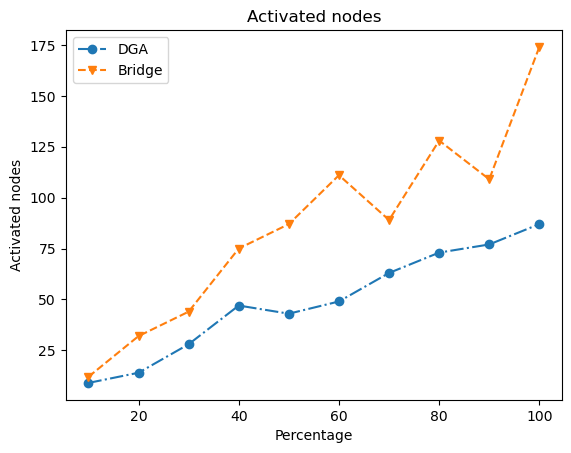

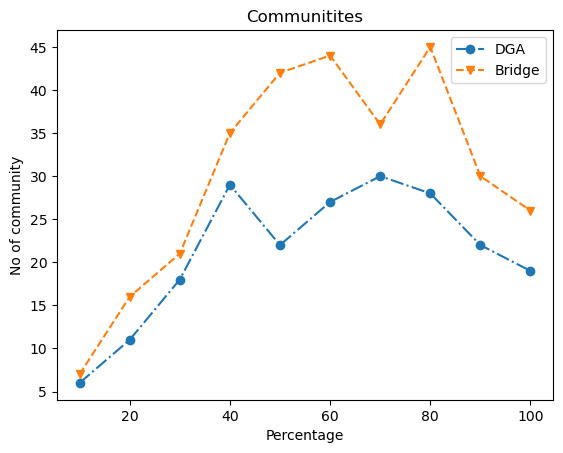

communities: 2
Time: 2


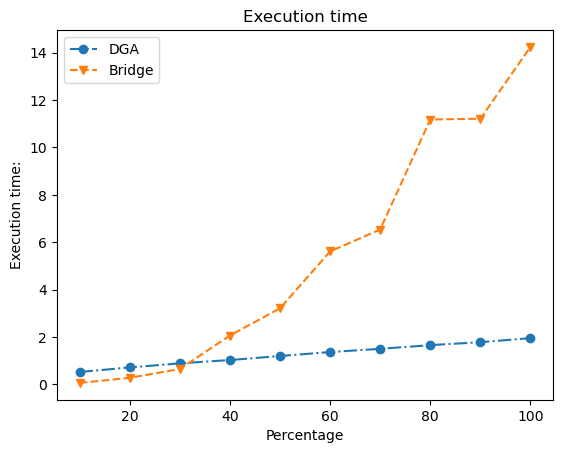

(2, 31)


In [36]:
result=executeDiv('LFR_500_0.8')
processResults()

In [37]:
# generate_graphs(result,False)

In [38]:
import pandas as pd 
processResults()

(2, 31)
